In [1]:
from numpy import *
import matplotlib.pyplot as plt
from scipy import optimize
import pandas as pd

This time, we are going to price a 30-year MBS with a fixed $WAS = 8\%$ (monthly cash flows starting in January of this year). The Notional Amount of the Loan is $\$100,000$. The CIR model of interest rates we use is 

$$
dr_t = \kappa (\overline{r} - r_t) dt + \sigma \sqrt{r_t} dW_t
$$
with
$$
r_0 = 0.078, \kappa = 0.6, \overline{r} = 0.08, \sigma =0.12
$$

In [2]:
CIR_param = {'r0': 0.078, 'kappa': 0.6, 'r_bar': 0.08, 'sigma': 0.12}
MBS_param = {'WAC': 0.08, 'NAL': 100000, 'T': 30}

# P1: Numerix Prepayment Model
- To calculate the price of the MBS, we first generate the time series including short interest rates, 10-year spot rates, and discount rates using Monte Carlo Simulation.

- Then based on rates we can calculate the present values of the cash flows. The price of the MBS is the sum of these present values.

In [3]:
def CIR_Prepayment_MC(T, simu_paths, **param):
    """Monte Carlo Simulation of CIR model interest rates for Numerix Prepayment Model
    Args:
        T (int): The term of the time
        simu_paths (int): Path number for Monte Carlo Simulation

    Returns:
        rt (float matrix): Short term interest rate along the term
        r10 (float matrix): 10-year-rate
        n (int): number of period of the mortgage
        d (float matrix): discount factor for each cash flow along each rate paths evaluated at t = 0
    """
    # CIR model parameters
    r0 = param['r0']
    sigma = param['sigma']
    kappa = param['kappa']
    r_bar = param['r_bar']
    
    dt = 1/12/30 # 1/30 month step
    N_time = int(floor(T/dt)) # time grid
    
    # stochastic part
    dW_t = sqrt(dt) * random.standard_normal((N_time, simu_paths))
    
    # CIR dynamics to calculate short interest rate
    r = zeros((N_time, simu_paths))
    r[0] = ones(simu_paths) * r0
    for i in range(N_time-1):
        r[i+1] = r[i] + kappa*(r_bar - r[i])*dt + sigma*sqrt(maximum(r[i],0))*dW_t[i]
    
    rt = r[0::30] # short rate at the beginning of each period
    n = rt.shape[0] # number of periods
    
    # explicitly calculate 10-year ZCB value using CIR model
    T_10 = 10
    
    # explicit solutions factors
    h1 = sqrt(kappa**2 + 2 * sigma**2)
    h2 = (kappa + h1) / 2.
    h3 = (2 * kappa * r_bar) / sigma**2
    
    B_10 = (exp(h1 * T_10) - 1) / (h2 * (exp(h1 * T_10) - 1) + h1)
    A_10 = ((h1*exp(h2 * T_10)) / (h2 * (exp(h1 * T_10) - 1) + h1))**h3
    
    P_10 = A_10*exp(-B_10*rt) # 10-year ZCB value at the beginning of each month
    
    r10 = -0.1 * log(P_10) # annualized spot rate
    
    R = -dt * cumsum(r, axis = 0)[29::30]
    d = exp(R) # path dependent discount factor
    
    return  rt, r10, n, d

In [4]:
def MBS_Numerix_Prepayment(simu_paths, CIR_param, MBS_param):
    """MBS Pricing using Monte Carlo Simulation of CIR model interest rates for Numerix Prepayment Model
    Args:
        simu_paths (int): Path number for Monte Carlo Simulation
        CIR_param (packed list): CIR model dynamics parameters
            taking: r0, r_bar, kappa, sigma
        MBS_param (packed list): MBS parameters
            taking: T, WAC, NAL
    Returns:
        price (float): price of the MBS at time t = 0
    """
    R = MBS_param['WAC'] # Weighted-average Characteristic
    NAL = MBS_param['NAL'] # Notional Amount of Loan
    T = MBS_param['T'] # Maturity of Loan
    
    (rt, r10, n, d) = CIR_Prepayment_MC(T, simu_paths, **CIR_param)
    
    CPR, BU, SG, SP, IP, PP, MP, TPP, c, dc, dIP, dTPP = [zeros_like(rt) for _ in range(12)]

    r = R / 12. # monthly rate
    SY_annual_unit = [.94, .76, 0.74, .95, .98, .92, .98, 1.1, 1.18, 1.22, 1.23, .98]
    SY = repeat(tile(SY_annual_unit, (1, T)), simu_paths, axis = 0).transpose()
    RI = 0.28 + 0.14 * arctan(-8.57 + 430*(R - r10))

    PV = zeros((n+1, simu_paths))
    PV_0 = NAL * ones(simu_paths)
    PV[0] = PV_0

    for i in range(n):
        BU[i] = 0.3 + 0.7 * PV[i] / PV_0
        
        SG[i] = minimum(1, (i+1)/30)

        CPR[i] = RI[i] * BU[i] * SG[i] * SY[i]

        IP[i] = PV[i] * r

        MP[i] = IP[i] / (1 - (1 + r)**(i - n))

        SP[i] = MP[i] - IP[i]

        PP[i] = (PV[i] - SP[i])*(1 - (1 - CPR[i])**(1/12))

        TPP[i] = SP[i] + PP[i]

        c[i] = MP[i] + PP[i]

        dc[i] = c[i] * d[i]
        
        dIP[i] = IP[i] * d[i]
        
        dTPP[i] = TPP[i] * d[i]

        PV[i+1] = PV[i] - TPP[i]

    price = mean(sum(dc, axis = 0))
    d_IO_PO = (dIP, dTPP)
    return price, dc, d_IO_PO

## (a) Price of the MBS using Numerix Prepayment Model
* Input: 
    * Simulation Paths Numbers
    * CIR Model Parameters
        * $r_0, \kappa, \overline{r}, \sigma$
    * MBS Parameters
        * T, WAC, Notional Amount of the Load (NAL)
* Output:
    * Price of the MBS
    * Discounted Cash Flows (along all paths)
    * Discounted Cash Flows from IO and PO tranches

In [5]:
price1a,_,_ = MBS_Numerix_Prepayment(10000, CIR_param, MBS_param)
print('The price of the MBS is {p:f}'.format(p = price1a))

The price of the MBS is 100845.719940


As we are using path-dependent discount factor and cashflows, the price of the MBS is volatile in that the timing of prepayment has significant effect on the cash flows.

## (b) Price of the MBS with $\kappa$ in 0.3 to 0.9 (increments of 0.1)

In [6]:
kappa = arange(0.3, 0.9+0.1, 0.1)
def P1b(kappa, simu_paths, MBS_param):
    
    prices = zeros_like(kappa)
    for index, k_ in enumerate(kappa):
        para = {'r0': 0.078, 'kappa': k_, 'r_bar': 0.08, 'sigma': 0.12}
        prices[index],_,_ = MBS_Numerix_Prepayment(simu_paths, para, MBS_param)
    return prices

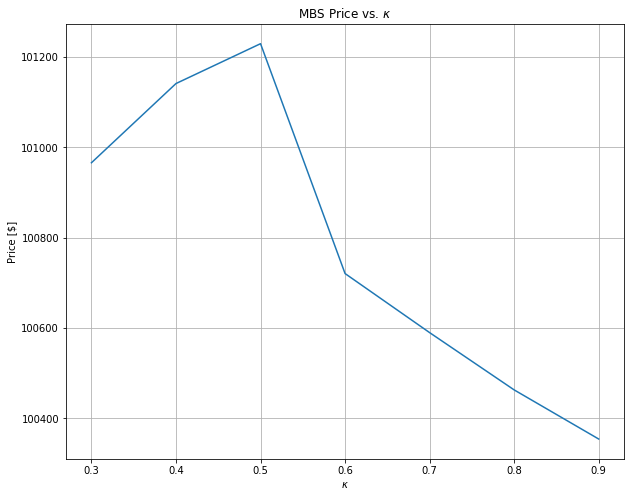

In [7]:
price1b = P1b(kappa, 10000, MBS_param)

plt.figure(figsize=(10, 8))
plt.plot(kappa, price1b)
plt.title('MBS Price vs. $\kappa$')
plt.xlabel('$\kappa$')
plt.ylabel('Price [$]')
plt.grid()
plt.show()

In [8]:
df_1b = {'kappa':kappa, 'price': price1b}
df_price1b = pd.DataFrame(data = df_1b)
df_price1b

,kappa,price
0,0.3,100965.849446
1,0.4,101141.107969
2,0.5,101229.303862
3,0.6,100720.661059
4,0.7,100589.995443
5,0.8,100463.217033
6,0.9,100354.519426


As we discussed previously, the kinked plot indicates that different prepayment timing along each interest rate path has significant effect on the simulated price of MBS. If we raise the path number to even larger scales, it is feasible to get more accurate answers.

## (c) Price of MBS with $\overline{r}$ in 0.03 to 0.09 (increments of 0.01)

In [9]:
r_bar = arange(0.03, 0.09+0.01, 0.01)
def P1c(r_bar, simu_paths, MBS_param):
    
    prices = zeros_like(r_bar)
    for index, r_ in enumerate(r_bar):
        para = {'r0': 0.078, 'kappa': 0.6, 'r_bar': r_, 'sigma': 0.12}
        prices[index],_,_ = MBS_Numerix_Prepayment(simu_paths, para, MBS_param)
    return prices

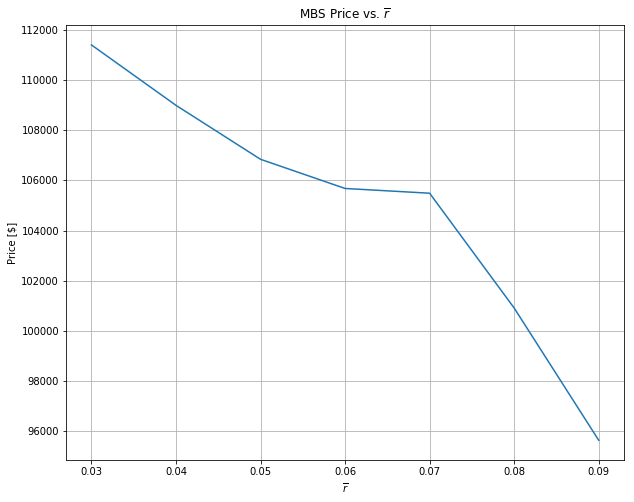

In [10]:
price1c = P1c(r_bar, 10000, MBS_param)
plt.figure(figsize=(10, 8))
plt.plot(r_bar, price1c)
plt.title('MBS Price vs. $\overline{r}$')
plt.xlabel('$\overline{r}$')
plt.ylabel('Price [$]')
plt.grid()
plt.show()

In [11]:
df_1c = {'r_bar':r_bar, 'price': price1c}
df_price1c = pd.DataFrame(data = df_1c)
df_price1c

,price,r_bar
0,111401.403459,0.03
1,108993.337624,0.04
2,106842.171897,0.05
3,105679.633338,0.06
4,105490.472405,0.07
5,100913.962244,0.08
6,95643.931011,0.09


# P2: Public Securities Association's (PSA) Model of Prepayment
- To calculate the price of the MBS, we first generate the time series for discount rates using Monte Carlo Simulation.

- Then based on discount rates we can calculate the present values of the cash flows. The price of the MBS is the sum of these present values.

In [12]:
def MBS_PSA_Prepayment(simu_paths, CIR_param, MBS_param):
    """MBS Pricing using Monte Carlo Simulation of CIR model interest rates for PSA Prepayment Model
    Args:
        simu_paths (int): Path number for Monte Carlo Simulation
        CIR_param (packed list): CIR model dynamics parameters
            taking: r0, r_bar, kappa, sigma
        MBS_param (packed list): MBS parameters
            taking: T, WAC, NAL
    Returns:
        price (float): price of the MBS at time t = 0
    """
    R = MBS_param['WAC'] # Weighted-average Characteristic
    NAL = MBS_param['NAL'] # Notional Amount of Loan
    T = MBS_param['T'] # Maturity of Loan
    
    (_, _, n, d) = CIR_Prepayment_MC(T, simu_paths, **CIR_param)
    
    SP, IP, PP, MP, TPP, c, dc = [zeros((n, simu_paths)) for _ in range(7)]

    r = R / 12. # monthly rate

    PV, CPR = [zeros((n+1, simu_paths)) for _ in range(2)]
    PV_0 = NAL * ones(simu_paths)
    PV[0] = PV_0
    CPR_0 = zeros(simu_paths)
    CPR[0] = CPR_0
    
    for i in range(n):
        if i <= 29:
            CPR[i+1] = CPR[i] + 0.002
        else:
            CPR[i+1] = CPR[i]

        IP[i] = PV[i] * r

        MP[i] = IP[i] / (1 - (1 + r)**(i - n))

        SP[i] = MP[i] - IP[i]

        PP[i] = (PV[i] - SP[i])*(1 - (1 - CPR[i+1])**(1/12))

        TPP[i] = SP[i] + PP[i]

        c[i] = MP[i] + PP[i]

        dc[i] = c[i] * d[i]

        PV[i+1] = PV[i] - TPP[i]

    price = mean(sum(dc, axis = 0))
    return price

## (a) Price of MBS using PSA Model of prepayments
* Input: 
    * Simulation Paths Numbers
    * CIR Model Parameters
        * $r_0, \kappa, \overline{r}, \sigma$
    * MBS Parameters
        * T, WAC, Notional Amount of the Load (NAL)
* Output:
    * Price of the MBS

In [24]:
price2a = MBS_PSA_Prepayment(10000, CIR_param, MBS_param)
print('The price of the MBS using the PSA model is {p2:f}'.format(p2 = price2a))

The price of the MBS using the PSA model is 100789.676409


## (b) Price of MBS with $\kappa$ ranging from 0.3 to 0.9 (in increments of 0.1)

In [14]:
def P2b(kappa, simu_paths, MBS_param):
    
    prices = zeros_like(kappa)
    for index, k_ in enumerate(kappa):
        para = {'r0': 0.078, 'kappa': k_, 'r_bar': 0.08, 'sigma': 0.12}
        prices[index] = MBS_PSA_Prepayment(simu_paths, para, MBS_param)
    return prices

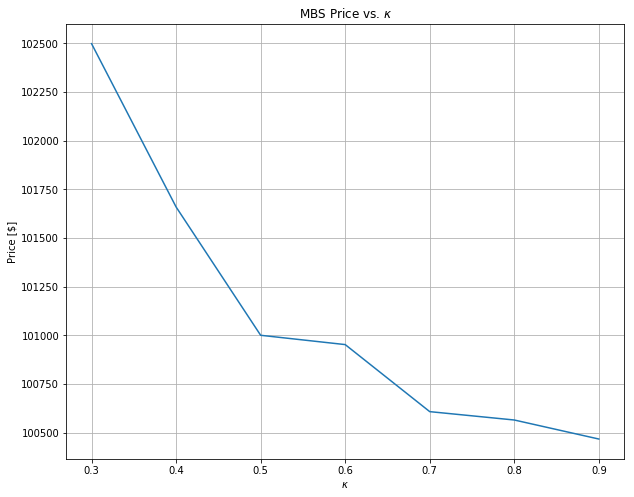

In [15]:
price2b = P2b(kappa, 10000, MBS_param)
plt.figure(figsize=(10, 8))
plt.plot(kappa, price2b)
plt.title('MBS Price vs. $\kappa$')
plt.xlabel('$\kappa$')
plt.ylabel('Price [$]')
plt.grid()
plt.show()

In [16]:
df_2b = {'kappa':kappa, 'price': price2b}
df_price2b = pd.DataFrame(data = df_2b)
df_price2b

,kappa,price
0,0.3,102498.623699
1,0.4,101659.807275
2,0.5,101000.908934
3,0.6,100953.126771
4,0.7,100608.734613
5,0.8,100565.781915
6,0.9,100468.044798


# P3: Option-Adjusted-Spread (OAS) for Numerix-Prepayment Model with Market PRice of MBS being \$ 110,000
* Input: 
    * Market Price of the MBS
    * Simulation Paths Numbers
    * CIR Model Parameters
        * $r_0, \kappa, \overline{r}, \sigma$
    * MBS Parameters
        * T, WAC, Notional Amount of the Load (NAL)
* Output:
    * OAS of the MBS

In [17]:
def OAS_Numerix_Prepayment(mkt_price, simu_paths, CIR_param, MBS_param):
    """Option-Adjusted-SPread (OAS) for Numerix-Prepayment model
    Args:
        mkt_price (float): Current Market Price of the MBS
        simu_paths (int): Path number for Monte Carlo Simulation
        CIR_param (packed list): CIR model dynamics parameters
            taking: r0, r_bar, kappa, sigma
        MBS_param (packed list): MBS parameters
            taking: T, WAC, NAL
    Returns:
        root (float): OAS of the MBS
        ds (float): discounted cash flows for all paths
    """
    _,dc,_ = MBS_Numerix_Prepayment(simu_paths, CIR_param, MBS_param)
    
    (n, M) = dc.shape # grid dimension
    t = arange(1, n+1, 1) / 12.
    tt = repeat(t.reshape((n, 1)), M, axis = 1) # broadcast time grid to each path
    
    def OAS(x):
        K = exp(-x*tt) * dc
        return mean(sum(K, axis = 0)) - mkt_price
    
    root = optimize.newton(OAS, 0)
    return root, dc

In [18]:
p3, dc3 = OAS_Numerix_Prepayment(110000, 10000, CIR_param, MBS_param)
print('The Option-Adjusted-Spread (OAS) for the Numerix-Prepayment model case\n with Market Price of MBS being $ 110,000 is {p:f}.'.format(p=p3))

The Option-Adjusted-Spread (OAS) for the Numerix-Prepayment model case
 with Market Price of MBS being $ 110,000 is -0.012832.


# P4: OAS_adjusted Duration and Convexity of the MBS in previous section
* Input: 
    * x (float): OAS of the MBS
    * y (float): change value of OAS [in bps]
    * mkt_price (float): market price of the MBS
    * dc (float): discounted cash flows
* Output:
    * duration, convexity (float):OAS-adjusted duration and convexity

In [19]:
def OAS_Duration_Convexity(x, y, mkt_price, dc):
    """OAS-adjusted Duration and Convexity for Numerix-Prepayment model in previous section
    Args:
        x (float): OAS of the MBS
        y (float): change value of OAS [in bps]
        mkt_price (float): market price of the MBS
        dc (float): discounted cash flows
    Returns:
        OAS-adjusted duration and convexity
    """
    oas_plus = x + y
    oas_minus = x - y
    
    (n, M) = dc.shape
    
    # broadcast the time grid to each path
    t = arange(1, n+1, 1) / 12.
    tt = repeat(t.reshape((n, 1)), M, axis = 1)
    
    # new price
    p_plus = mean(sum(dc*exp(-oas_plus*tt), axis = 0))
    p_minus = mean(sum(dc*exp(-oas_minus*tt), axis = 0))
    p_0 = mkt_price
    
    duration = (p_minus - p_plus)/(2*y*p_0)
    convexity = (p_plus + p_minus - 2*p_0) / (2*p_0*y**2)
    return duration, convexity

In [25]:
(p4_D, p4_C) = OAS_Duration_Convexity(p3, 0.0005, 110000, dc3)
print('The OAS-adjusted duration is {d:f}, and the convexity is {c:f}'.format(d = p4_D, c = p4_C))

The OAS-adjusted duration is 7.214100, and the convexity is 45.759503


# P5: Price the IO and PO tranches for the MBS above using Numerix Prepayment Model with $\overline{r}$ in 0.03 to 0.09 range

In [21]:
def p5(r_bar, simu_paths, MBS_param):
    
    prices_IO, prices_PO = [zeros_like(r_bar) for _ in range(2)]
    
    for index, r_ in enumerate(r_bar):
        
        para = {'r0': 0.078, 'kappa': 0.6, 'r_bar': r_, 'sigma': 0.12}
        
        _,_,(IO, PO) = MBS_Numerix_Prepayment(simu_paths, para, MBS_param)
    
        prices_IO[index] = mean(sum(IO, axis = 0))
        prices_PO[index] = mean(sum(PO, axis = 0))
    
    return prices_IO, prices_PO

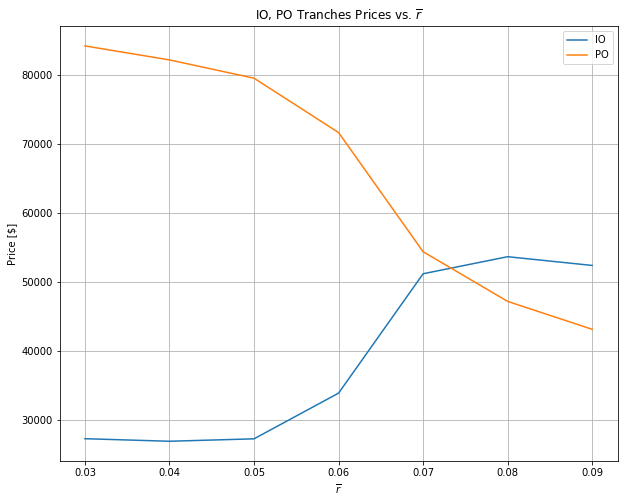

In [22]:
(p5IO, p5PO) = p5(r_bar, 10000, MBS_param)
plt.figure(figsize=(10, 8))
plt.plot(r_bar, p5IO, r_bar, p5PO)
plt.title('IO, PO Tranches Prices vs. $\overline{r}$')
plt.xlabel('$\overline{r}$')
plt.ylabel('Price [$]')
plt.legend(['IO', 'PO'])
plt.grid()
plt.show()

In [23]:
df_5 = {'r_bar':r_bar, 'IO tranches price': p5IO, 'PO tranches price': p5PO}
df_price5 = pd.DataFrame(data = df_5)
df_price5

,IO tranches price,PO tranches price,r_bar
0,27217.508356,84251.461422,0.03
1,26845.916285,82217.858815,0.04
2,27199.129707,79562.870550,0.05
3,33832.363840,71672.824513,0.06
4,51168.235783,54366.216848,0.07
5,53643.965549,47152.867173,0.08
6,52373.425688,43102.840770,0.09
